# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install -U smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import boto3
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()
bucket = 'ayesha-udacity-project3'
s3_output_location = f"s3://{bucket}/models/image_model"
sagemaker_session = sagemaker.Session()
session = boto3.session.Session()
region = session.region_name

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [27]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-03-04 07:18:43--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

100%[====================================>] 1,132,023,110 47.1MB/s   in 24s    

2023-03-04 07:19:07 (45.5 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


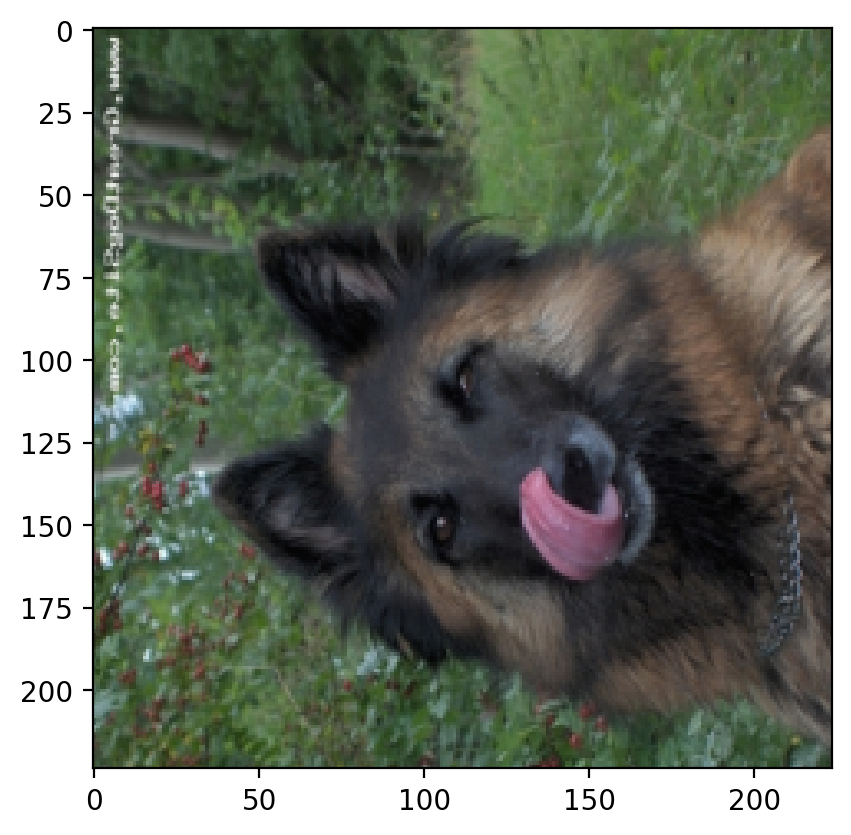

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                transforms.Resize((224, 224)),
                                 transforms.ToTensor()])
dataset = datasets.ImageFolder('./dogImages/train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
images, labels = next(iter(dataloader))
plt.imshow(images[0].T)
# for step, (inputs, labels) in enumerate(dataloader):
    # print(f"Step: {step}, Inputs: {inputs}, labels: {labels}")
    # plt.imshow(inputs[0].T)


In [79]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket)
print("input spec (in this case, just an S3 path): {}".format(inputs))

KeyboardInterrupt: 

In [6]:
data_channels = {
    "train": f"s3://{bucket}/data/train/",
    "valid": f"s3://{bucket}/data/valid/",
    "test": f"s3://{bucket}/data/test/",
}

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "momentum": ContinuousParameter(0.0, 1.0),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

tuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [74]:
estimator.fit(
    data_channels, 
    wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-06-04-01-47-126


2023-03-06 04:01:47 Starting - Starting the training job...
2023-03-06 04:02:03 Starting - Preparing the instances for training......
2023-03-06 04:02:50 Downloading - Downloading input data......
2023-03-06 04:03:51 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-06 04:04:08,086 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-06 04:04:08,088 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-06 04:04:08,097 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-06 04:04:08,099 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-06 04:04:08,257 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-06 04:04:08,270 sagemaker-training-toolkit INFO     N

In [75]:
# TODO: Fit your HP Tuner
tuner.fit(data_channels, wait=True) # TODO: Remember to include your data channels

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230306-0409


.................................................................................................................................................................................................................!


In [76]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_hp = best_estimator.hyperparameters()
best_hp


2023-03-06 04:19:01 Starting - Preparing the instances for training
2023-03-06 04:19:01 Downloading - Downloading input data
2023-03-06 04:19:01 Training - Training image download completed. Training in progress.
2023-03-06 04:19:01 Uploading - Uploading generated training model
2023-03-06 04:19:01 Completed - Resource reused by training job: pytorch-training-230306-0409-004-3789c37a


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'lr': '0.08596215306782015',
 'momentum': '0.5712572770971469',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-06-04-09-50-945"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-100382494584/pytorch-training-2023-03-06-04-09-50-945/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [67]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    collection_configs=[
        CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": "CrossEntropyLoss_output.*",
                             "train.save_interval": "1",
                             "eval.save_interval": "5"
                           })
    ]
)

In [68]:

hyperparameters = {
    "batch-size": 256,
    "gpu": True,
    "epochs": 5,
    "lr": 0.08596215306782015,
    "momentum": 0.5712572770971469
}

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogImage-pytorch",
    role=role,
    instance_count=1,
    # instance_type="ml.m5.2xlarge",
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
    output_path=s3_output_location,
)

In [69]:
# TODO: Create and fit an estimator

estimator.fit(
    data_channels,
    wait = True
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-03-07 01:46:14 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2023-03-07 01:47:10 Starting - Preparing the instances for training......
2023-03-07 01:48:00 Downloading - Downloading input data......
2023-03-07 01:49:08 Training - Downloading the training image..................
2023-03-07 01:52:11 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-07 01:52:34,126 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-07 01:52:34,157 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-07 01:52:34,159 sagemaker_pytorch_container.training INFO     Invoking user trainin

In [70]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
job_name

'smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503'

In [72]:
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

In [73]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-07 01:58:00.592 ip-172-16-22-177.ec2.internal:9927 INFO s3_trial.py:42] Loading trial debug-output at path s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/debug-output
[2023-03-07 01:58:00.844 ip-172-16-22-177.ec2.internal:9927 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4645 more expected)', IncompleteRead(0 bytes read, 4645 more expected)) while reading s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/debug-output/index/000000000/000000000018_worker_0.json . Will retry now


In [74]:
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.relu_input_2', 'layer3.2.relu_input_0', 'layer3.2.relu_input_1', 'layer3.2.relu_input_2', 'layer3.3.relu_input_0', 'layer3.3.relu_input_1', 'layer3.3.relu_input_2', 'layer3.4.relu_input_0', 'layer3.4.relu_input_1', 'layer3.4.relu_input_2', 'layer3.5.

In [75]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()


ProfilerConfig:{'S3OutputPath': 's3://ayesha-udacity-project3/models/image_model', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/profiler-output


Profiler data from system is available


In [76]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-07 01:58:19.661 ip-172-16-22-177.ec2.internal:9927 INFO metrics_reader_base.py:134] Getting 10 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [77]:
rule_output_path = estimator.output_path + "/" + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output'

In [78]:
!aws s3 ls {rule_output_path} --recursive

2023-03-07 01:57:37     415422 models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-07 01:57:36     270018 models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-07 01:57:32        192 models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-07 01:57:32      16448 models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-07 01:57:32       2050 models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-07 01:57:32        326 models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/pr

In [79]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://ayesha-udacity-project3/models/image_model/smdebugger-dogImage-pytorch-2023-03-07-01-46-13-503/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
do

In [80]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
print(profiler_report_name)

ProfilerReport


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [81]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


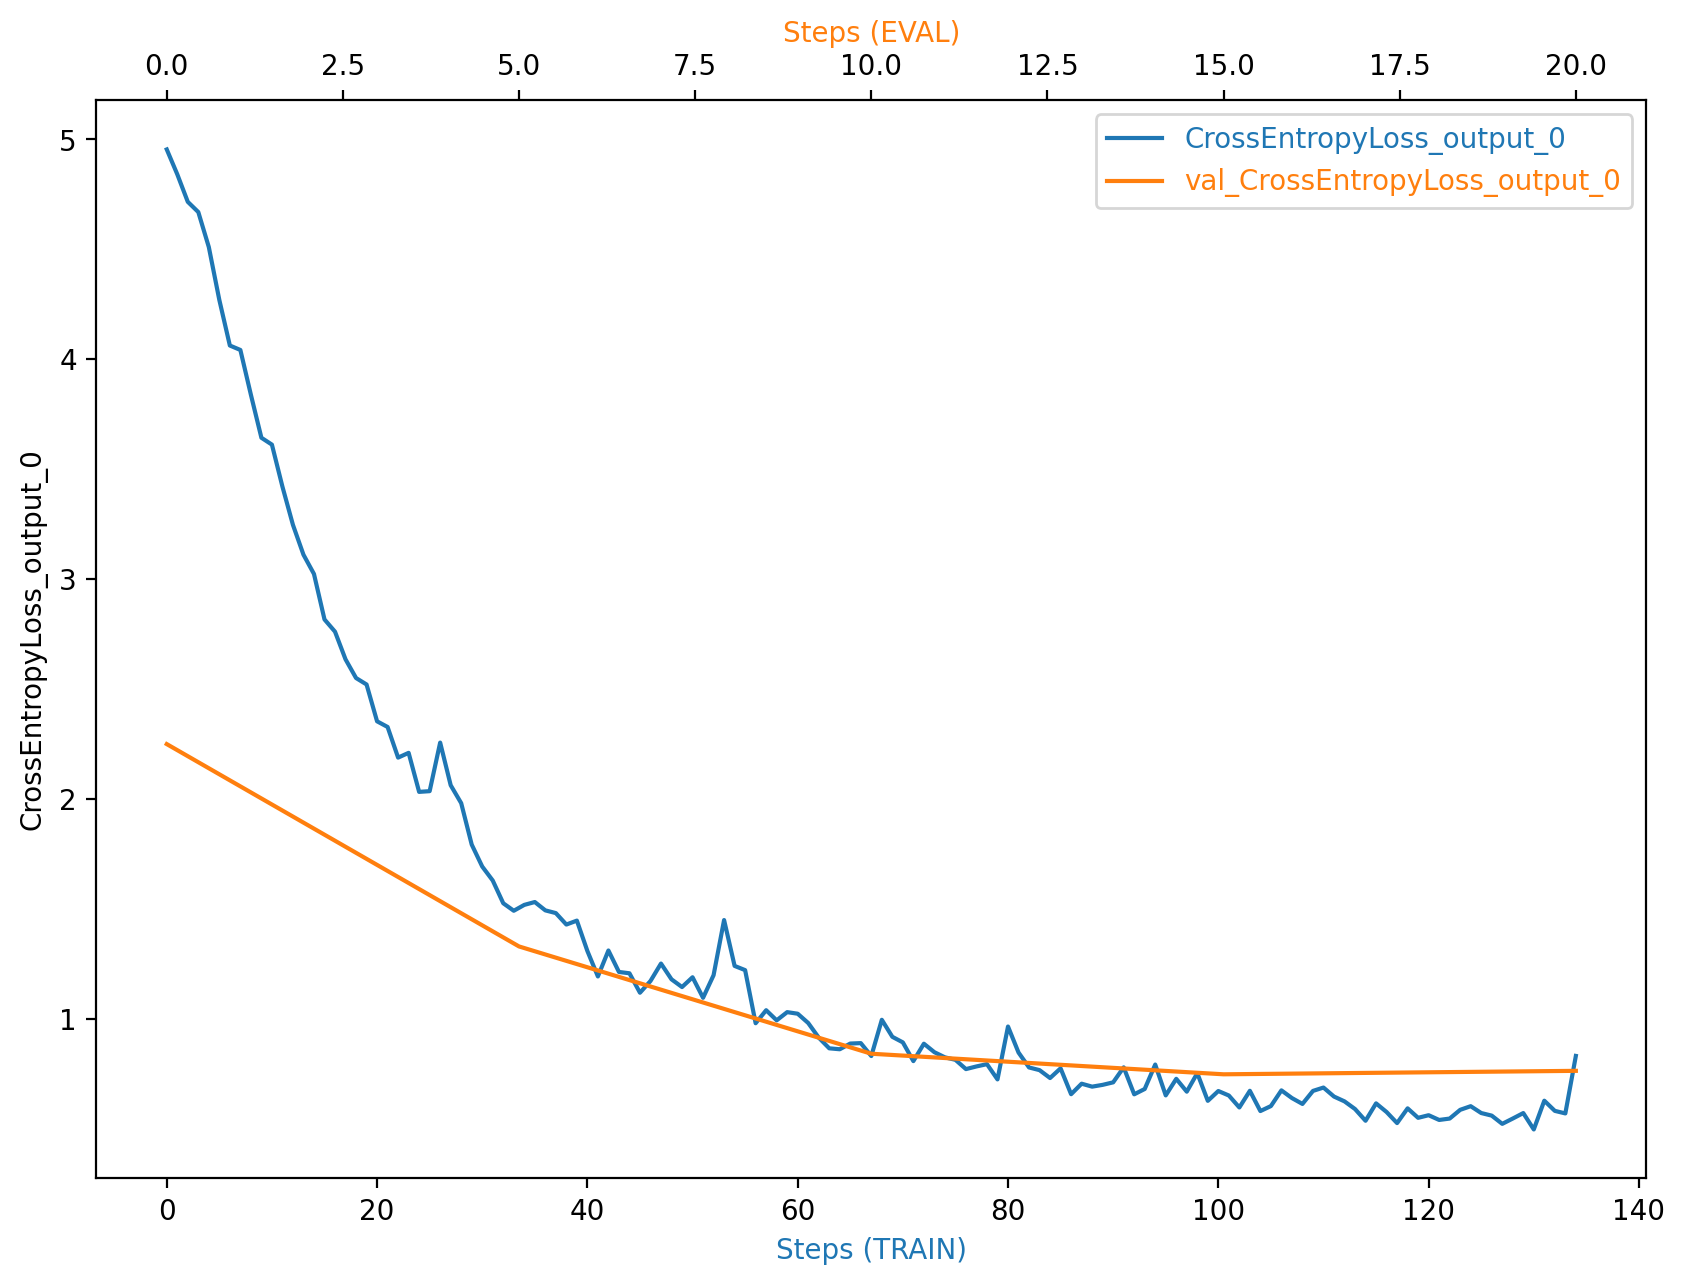

In [83]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

## Model Deploying

In [33]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: smdebugger-dogImage-pytorch-2023-03-06-07-25-38-642
INFO:sagemaker:Creating endpoint-config with name smdebugger-dogImage-pytorch-2023-03-06-07-25-38-642
INFO:sagemaker:Creating endpoint with name smdebugger-dogImage-pytorch-2023-03-06-07-25-38-642


------------!

Actual Label: 004.Akita
Predicted Label: 005.Alaskan_malamute


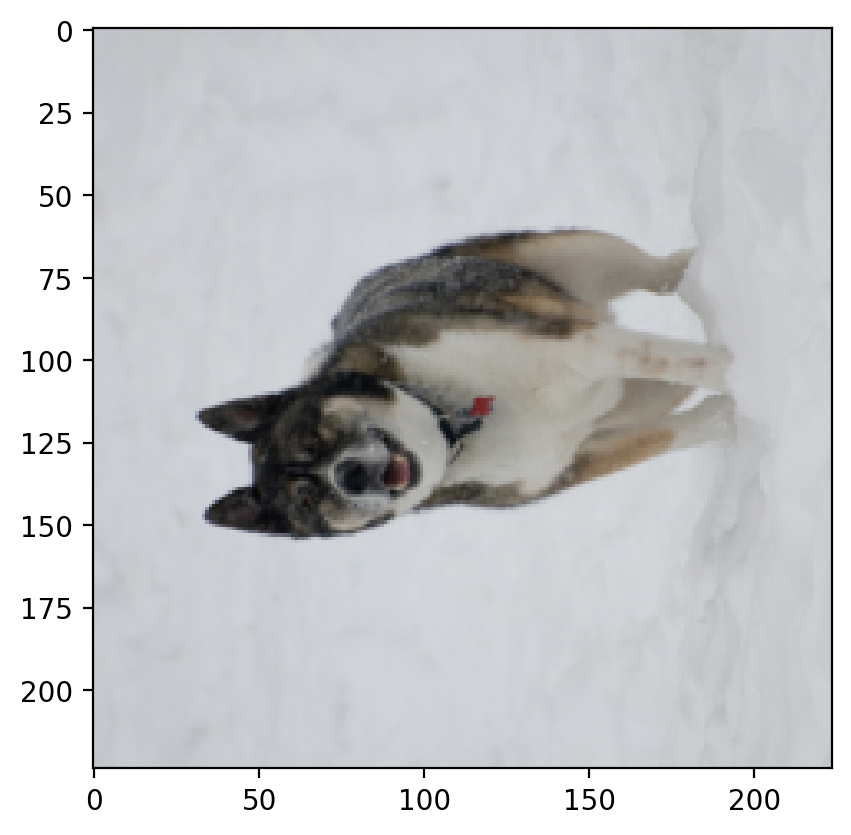

In [40]:
from train_model import model_fn, create_data_loaders
import numpy as np
import random
import os
from PIL import Image
import cv2

data_dir = './dogImages/test'

label_list = sorted(os.listdir(data_dir))

test_loader = create_data_loaders(data_dir, batch_size=4)


# for e in range(4):
images, labels = next(iter(test_loader))
print(f"Actual Label: {label_list[labels[0]]}")
response = predictor.predict(images)
labeled_predictions = list(zip(range(133), response[0]))
labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print(f"Predicted Label: {label_list[labeled_predictions[0][0]]}")
plt.imshow(images[0].T)


In [41]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: smdebugger-dogImage-pytorch-2023-03-06-07-25-38-642
INFO:sagemaker:Deleting endpoint with name: smdebugger-dogImage-pytorch-2023-03-06-07-25-38-642
